In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [423]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12
from matplotlib import ticker
import numpy as np
import seaborn as sns
import xarray as xr

import covid19

def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

## data

In [424]:
#istat_path = 'comuni_giornaliero.csv'
#_, istat = covid19.data.read_istat(istat_path)

#istat_italy = istat.sel(year=2020).sum(['location', 'age_class'])
#istat_italy -= istat_italy.sel(time=slice(None, '2020-02-20')).mean()
#istat_italy = istat_italy.sel(time=slice(None, '2020-04-30'))
#istat_italy

In [425]:
# data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'

In [426]:
# data_italy_path = covid19.data.download('andamento-nazionale')
data_italy_regions_path = covid19.data.download('regioni')

In [427]:
ds_italy_regions = covid19.data.read_dpc(data_italy_regions_path)

ds_italy_regions['daily_deaths'] = ds_italy_regions['deaths'].diff('time')

ds_italy_regions['daily_deaths'].loc[{'location': 'Italy / Emilia-Romagna', 'time': '2020-08-15'}] = 0

ds_italy_regions['daily_confirmed'] = ds_italy_regions['confirmed'].diff('time')
ds_italy_regions['daily_screening'] = ds_italy_regions['casi_da_screening'].diff('time')
ds_italy_regions['daily_screening'].loc[{'time': slice(None, '2020-07-01')}] = np.nan
ds_italy_regions['daily_tests'] = ds_italy_regions['tests'].diff('time')
ds_italy_regions['daily_tested'] = ds_italy_regions['tested'].diff('time')

ds_italy_regions['daily_tpr'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['daily_tests']

ds_italy_regions['mortality'] = ds_italy_regions['deaths'] / ds_italy_regions['population'] * 1_000_000

ds_italy_regions['daily_mortality'] = ds_italy_regions['daily_deaths'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_prevalence'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_prevalence_screening'] = ds_italy_regions['daily_screening'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tests_pm'] = ds_italy_regions['daily_tests'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tested_pm'] = ds_italy_regions['daily_tested'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_severe_pm'] = ds_italy_regions['current_severe'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_critical_pm'] = ds_italy_regions['current_critical'] / ds_italy_regions['population'] * 1_000_000

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm', 'daily_prevalence_screening']:
    ds_italy_regions[kind + '7'] = ds_italy_regions[kind].rolling({'time': 7}).mean()

ds_italy_regions['daily_tpr7'] = ds_italy_regions['daily_confirmed7'] / ds_italy_regions['daily_tests7']

ds_italy_regions = ds_italy_regions.fillna(0)
ds_italy_regions = ds_italy_regions.assign_coords({'location': ('location', [l.partition(' / ')[2] for l in ds_italy_regions.location.values])})
ds_italy_regions = ds_italy_regions.drop(['lat', 'lon', 'state_region'])

# ds_italy_regions = ds_italy_regions.sel(time=slice(None, '2020-07-20'))

In [428]:
tmp = ds_italy_regions.sortby(-ds_italy_regions['population']).isel(time=-1)
tmp['dimessi_guariti'] = tmp['daily_confirmed7'] / tmp['daily_tests7'] * 100
REGIONS = list(tmp.location.astype(str).values)
tmp.to_dataframe()

current_severe  current_critical  deaths  \
location                                                          
Lombardia                         271                36   16917   
Lazio                             445                22     890   
Campania                          327                19     456   
Sicilia                           191                13     296   
Veneto                            125                10    2158   
Emilia-Romagna                    174                19    4474   
Piemonte                          140                 6    4154   
Puglia                            201                13     578   
Toscana                            88                21    1152   
Calabria                           27                 4      98   
Sardegna                           91                18     141   
Liguria                           140                16    1588   
Marche                             23                 2     989   
Abruzzo                            48                 5     474   
Friuli Venezia Giulia              20                 3     350   
Umbria                             27                 4      83   
Basilicata                          6                 1      28   
P.A. Trento                        10                 0     405   
P.A. Bolzano                       15                 2     292   
Molise                              5                 1      23   
Valle d'Aosta                       6                 0     146   

                       current_confirmed  confirmed    tests     tested  \
location                                                                  
Lombardia                           8935     104547  1928410  1197038.0   
Lazio                               5538      14179   774925   646453.0   
Campania                            4573      10089   532983   333778.0   
Sicilia                             2232       5846   429143   318845.0   
Veneto                              3045      25609  1780552   697466.0   
Emilia-Romagna                      4438      34225  1077776   620451.0   
Piemonte                            2304      34241   663091   403513.0   
Puglia                              2088       6944   372288   265618.0   
Toscana                             2827      13665   668896   450613.0   
Calabria                             445       1810   184055   181949.0   
Sardegna                            1595       3167   169119   143431.0   
Liguria                             1433      12407   282126   151550.0   
Marche                               621       7703   231949   136589.0   
Abruzzo                              679       4137   182106   117719.0   
Friuli Venezia Giulia                681       4345   378789   170885.0   
Umbria                               471       2192   186307   112361.0   
Basilicata                           165        631    66518    65708.0   
P.A. Trento                          534       5689   214020    92546.0   
P.A. Bolzano                         405       3281   159679    84628.0   
Molise                               104        586    39239    37847.0   
Valle d'Aosta                         48       1276    27415    19040.0   

                       dimessi_guariti  casi_da_sospetto_diagnostico  \
location                                                               
Lombardia                     1.245550                       93866.0   
Lazio                         1.871332                        7376.0   
Campania                      2.821072                        8599.0   
Sicilia                       2.135231                        3929.0   
Veneto                        1.221251                       20627.0   
Emilia-Romagna                1.487284                       30466.0   
Piemonte                      1.981368                       23816.0   
Puglia                        2.260617                        2227.0   
Toscana                       1.413

In [429]:
ds_italy = ds_italy_regions.sum('location')
ds_italy['mortality'] = ds_italy['deaths'] / ds_italy['population'] * 1_000_000
ds_italy['daily_mortality'] = ds_italy['daily_deaths'] / ds_italy['population'] * 1_000_000
ds_italy['daily_prevalence'] = ds_italy['daily_confirmed'] / ds_italy['population'] * 1_000_000
ds_italy['daily_prevalence_screening'] = ds_italy['daily_screening'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tests_pm'] = ds_italy['daily_tests'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tested_pm'] = ds_italy['daily_tested'] / ds_italy['population'] * 1_000_000
ds_italy['current_severe_pm'] = ds_italy['current_severe'] / ds_italy['population'] * 1_000_000
ds_italy['current_critical_pm'] = ds_italy['current_critical'] / ds_italy['population'] * 1_000_000

ds_italy['daily_tpr'] = ds_italy['daily_confirmed'] / ds_italy['daily_tests']

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm', 'daily_prevalence_screening']:
    ds_italy[kind + '7'] = ds_italy[kind].rolling({'time': 7}).mean()

ds_italy['daily_tpr7'] = ds_italy['daily_confirmed7'] / ds_italy['daily_tests7']

ds_italy.to_dataframe().tail(40)

current_severe  current_critical  deaths  current_confirmed  \
time                                                                      
2020-08-11             801                49   35215              13561   
2020-08-12             779                53   35225              13791   
2020-08-13             786                55   35231              14081   
2020-08-14             771                56   35234              14249   
2020-08-15             764                55   35392              14406   
2020-08-16             787                56   35396              14733   
2020-08-17             810                58   35400              14867   
2020-08-18             843                58   35405              15089   
2020-08-19             866                66   35412              15360   
2020-08-20             883                68   35418              16014   
2020-08-21             919                69   35427              16678   
2020-08-22             924                64   35430              17503   
2020-08-23             971                69   35437              18438   
2020-08-24            1045                65   35441              19195   
2020-08-25            1058                66   35445              19714   
2020-08-26            1055                69   35458              20753   
2020-08-27            1131                67   35463              21932   
2020-08-28            1178                74   35472              23035   
2020-08-29            1168                79   35473              24156   
2020-08-30            1251                86   35477              25205   
2020-08-31            1288                94   35483              26078   
2020-09-01            1380               107   35491              26754   
2020-09-02            1437               109   35497              27817   
2020-09-03            1505               120   35507              28915   
2020-09-04            1607               121   35518              30099   
2020-09-05            1620               121   35533              31194   
2020-09-06            1683               133   35541              32078   
2020-09-07            1719               142   35553              32993   
2020-09-08            1760               143   35563              33789   
2020-09-09            1778               150   35577              34734   
2020-09-10            1836               164   35587              35708   
2020-09-11            1849               175   35597              36767   
2020-09-12            1951               182   35603              37503   
2020-09-13            2042               187   35610              38509   
2020-09-14            2122               197   35624              39187   
2020-09-15            2222               201   35633              39712   
2020-09-16            2285               207   35645              40532   
2020-09-17            2348               212   35658              41413   
2020-09-18            2387               208   35668              42457   
2020-09-19            2380               215   35692              43161   

            confirmed     tests     tested  dimessi_guariti  \
time                                                          
2020-08-11     251237   7316918  4329697.0           202461   
2020-08-12     251713   7369576  4357027.0           202697   
2020-08-13     252235   7420764  4382656.0           202923   
2020-08-14     252809   7467487  4407524.0           203326   
2020-08-15     253438   7520610  4433461.0           203640   
2020-08-16     253915   7557417  4455931.0           203786   
2020-08-17     254235   7588083  4477310.0           203968   
2020-08-18     254636   7642059  4509997.0           204142   
2020-08-19     255278   7713154  4551287.0           204506   
2020-08-20     256118   7790596  4600949.0           204686   
2020-08-21     257065   7862592  4645892.0           204960   
2020-08-22     258136   7940266  4692505.0

## situation report

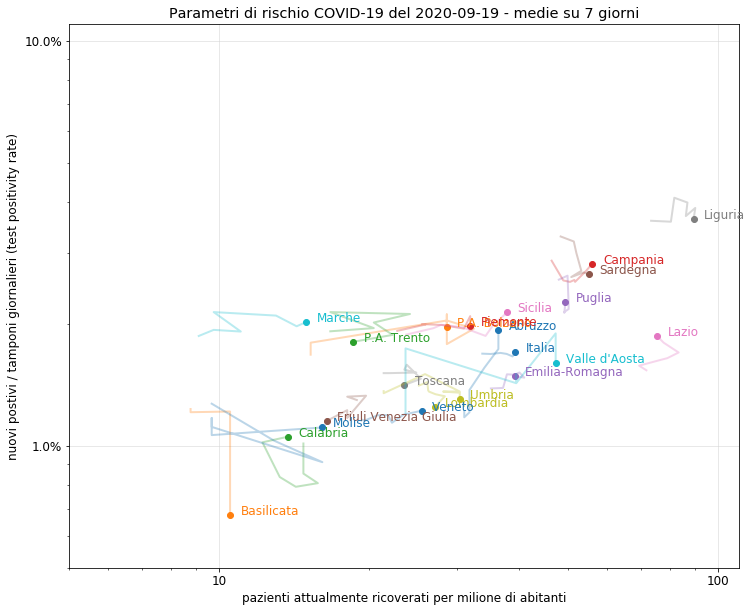

In [431]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_tpr7']
var1 = rr['current_severe_pm']

it_rr = ds_italy.isel(time=slice(-window, None))
it_var = it_rr['daily_tpr7'].expand_dims(location=['Italia'])
it_var1 = (it_rr['current_severe_pm']).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

ylim = (0.005, 0.11)
xlim = (5, 110)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su 7 giorni',
    xlabel='pazienti attualmente ricoverati per milione di abitanti',
    ylabel='nuovi postivi / tamponi giornalieri (test positivity rate)',
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

In [434]:
ds_italy_regions.sel(location="Lazio").to_dataframe()[['location', 'current_severe', 'current_critical', 'daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_tests7', 'daily_confirmed7', 'daily_deaths7', 'daily_tested7', 'confirmed', 'current_confirmed', 'daily_tpr7']].tail(20)


location  current_severe  current_critical  daily_tests  \
time                                                                 
2020-08-31    Lazio             328                 7      13093.0   
2020-09-01    Lazio             336                 8      10070.0   
2020-09-02    Lazio             343                 9      10544.0   
2020-09-03    Lazio             351                 9      11329.0   
2020-09-04    Lazio             363                 9      11744.0   
2020-09-05    Lazio             344                11      11740.0   
2020-09-06    Lazio             355                10      10786.0   
2020-09-07    Lazio             359                 9       9232.0   
2020-09-08    Lazio             354                 9       9363.0   
2020-09-09    Lazio             358                 9       9171.0   
2020-09-10    Lazio             372                 9      10432.0   
2020-09-11    Lazio             365                14      11621.0   
2020-09-12    Lazio             401                16      10339.0   
2020-09-13    Lazio             424                17       9580.0   
2020-09-14    Lazio             410                17       8818.0   
2020-09-15    Lazio             453                18       7727.0   
2020-09-16    Lazio             467                18       7911.0   
2020-09-17    Lazio             492                16       9381.0   
2020-09-18    Lazio             459                17      10558.0   
2020-09-19    Lazio             445                22      10097.0   

            daily_confirmed  daily_deaths  daily_tested  daily_tests7  \
time                                                                    
2020-08-31            148.0           0.0       11445.0  11690.571429   
2020-09-01            125.0           0.0        8824.0  11795.428571   
2020-09-02            130.0           0.0        9047.0  12014.857143   
2020-09-03            154.0           1.0       10879.0  12120.428571   
2020-09-04            171.0           0.0       10403.0  11796.285714   
2020-09-05            158.0           1.0        9770.0  11614.857143   
2020-09-06            122.0           1.0        9766.0  11329.428571   
2020-09-07            159.0           0.0        9085.0  10777.857143   
2020-09-08            129.0           0.0        8960.0  10676.857143   
2020-09-09            175.0           0.0        8464.0  10480.714286   
2020-09-10            163.0           1.0        8699.0  10352.571429   
2020-09-11            148.0           1.0       10047.0  10335.000000   
2020-09-12            155.0           1.0        8828.0  10134.857143   
2020-09-13            143.0           1.0        8271.0   9962.571429   
2020-09-14            181.0           0.0        7773.0   9903.428571   
2020-09-15            139.0           2.0        7658.0   9669.714286   
2020-09-16            165.0           0.0        6655.0   9489.714286   
2020-09-17            181.0           2.0        8002.0   9339.571429   
2020-09-18            193.0           0.0        8793.0   9187.714286   
2020-09-19            197.0           1.0        8609.0   9153.142857   

            daily_confirmed7  daily_deaths7  daily_tested7  confirmed  \
time                                                                    
2020-08-31        156.857143       0.428571    9804.285714      11191   
2020-09-01        154.285714       0.428571    9893.428571      11316   
2020-09-02        149.714286       0.285714   10186.142857      11446   
2020-09-03        150.000000       0.285714   10692.142857      11600   
2020-09-04        150.714286       0.142857   10362.000000      11771   
2020-09-05        148.857143       0.285714   10242.428571      11929   
2020-09-06        144.000000       0.428571   10019.142857      12051   
2020-09-07        145.571429       0.428571    9682.000000      12210   
2020-09-08        146.142857       0.428571    9701.428571      12339   
2020-09-09        152.571429       0.428571    9618.142857  

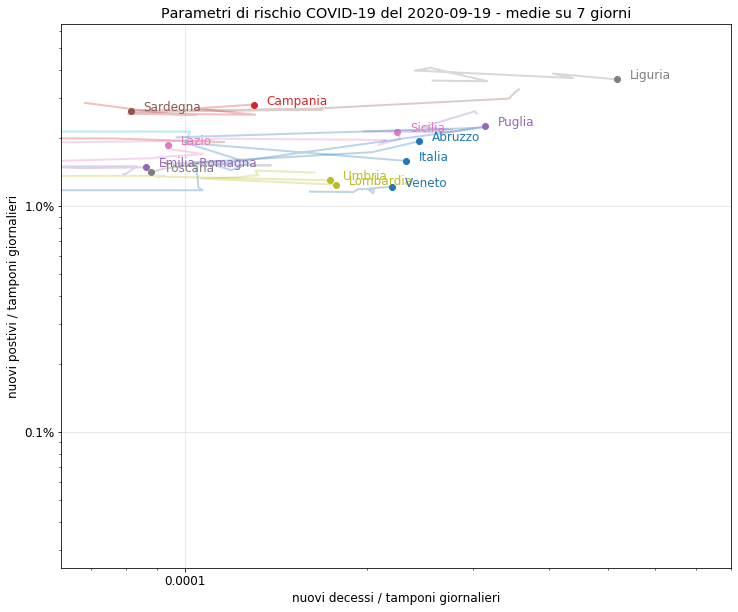

In [435]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_confirmed7'] / np.maximum(rr['daily_tests7'], 1)
var1 = rr['daily_deaths7'] / np.maximum(rr['daily_tests7'], 1)

it_var = (rr['daily_confirmed'].sum('location') / np.maximum(rr['daily_tests'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (rr['daily_deaths'].sum('location') / np.maximum(rr['daily_tests'], 1).sum('location')).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)

xlim = (0.0000625, 0.0008)
ylim = (0.00025, 0.064)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='nuovi decessi / tamponi giornalieri',
    ylabel='nuovi postivi / tamponi giornalieri',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

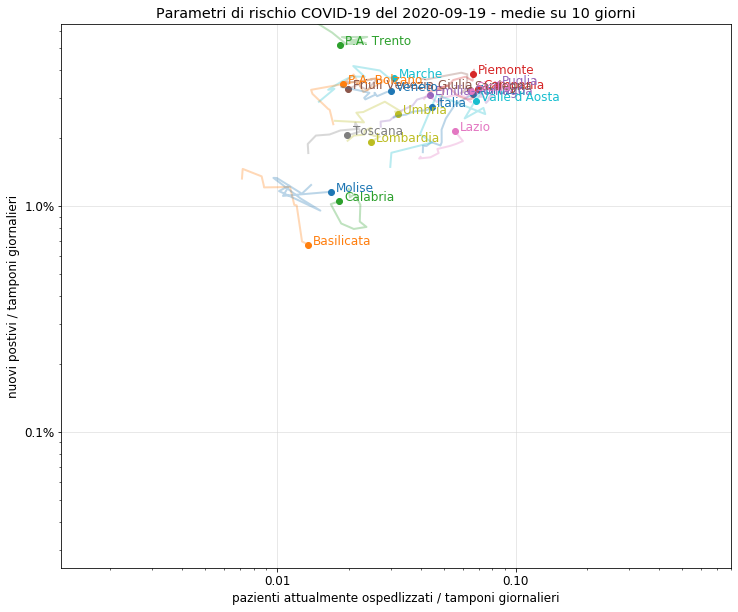

In [436]:
window = 10
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_confirmed7'] / np.maximum(rr['daily_tested7'], 1)
var1 = ds_italy_regions['current_severe'] / np.maximum(rr['daily_tested7'], 1)

it_var = (rr['daily_confirmed7'].sum('location') / np.maximum(rr['daily_tested7'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (ds_italy_regions['current_severe'].sum('location') / np.maximum(rr['daily_tested7'], 1).sum('location')).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)

xlim = (0.00125, 0.8)
ylim = (0.00025, 0.064)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='pazienti attualmente ospedlizzati / tamponi giornalieri',
    ylabel='nuovi postivi / tamponi giornalieri',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

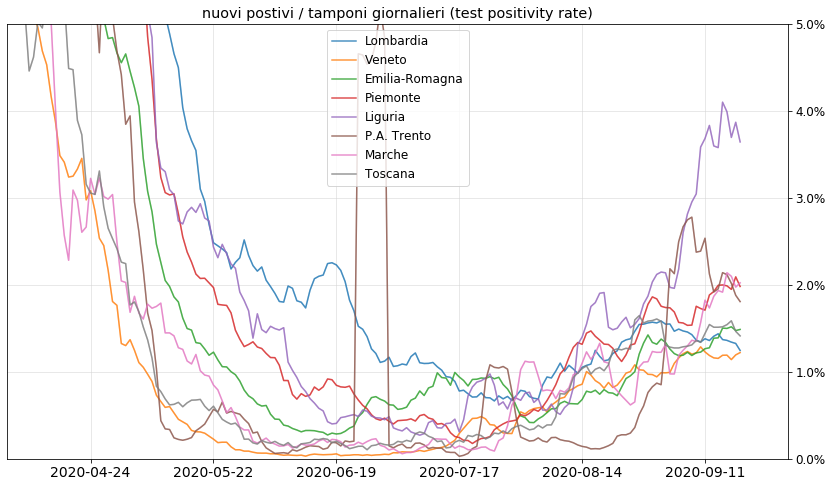

In [437]:
_, ax = covid19.plot.subplots(figsize=(14, 8))
ax.set(yscale='linear', title='nuovi postivi / tamponi giornalieri (test positivity rate)')
data = ds_italy_regions['daily_confirmed7'] / ds_italy_regions['daily_tests7']
covid19.plot.plot_xarray(data.sel(location=['Lombardia', 'Veneto', 'Emilia-Romagna', 'Piemonte', 'Liguria', 'P.A. Trento', 'Marche', 'Toscana']), foreground_hue=None, hue='location', ax=ax, date_interval=28, linewidth=1.5)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.set(ylim=(0., 0.05))
ax.set(xlim=(np.datetime64('2020-04-05'), np.datetime64('2020-09-30')))
_ = ax.legend()

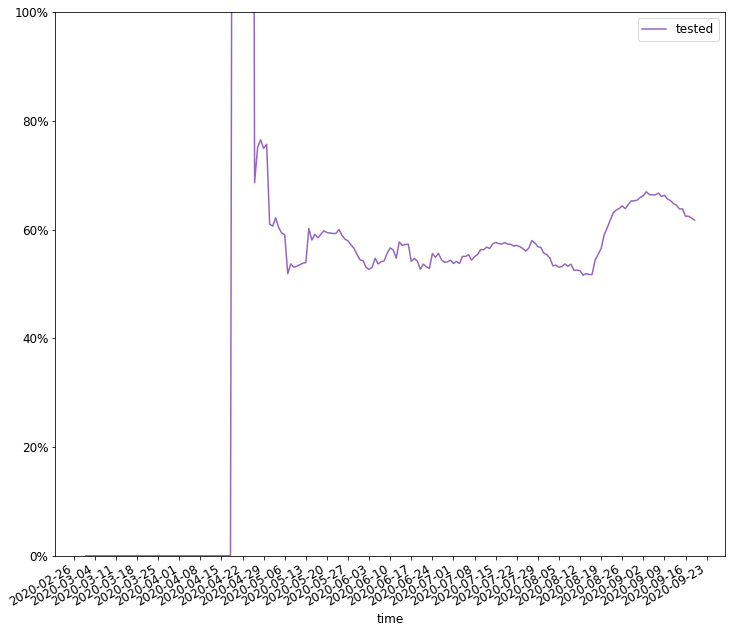

In [438]:
_, ax = plt.subplots()
ax.set(yscale='linear', title='nuovi postivi / tamponi giornalieri (test positivity rate)')
data = ds_italy['daily_tested_pm7'] / ds_italy['daily_tests_pm7']
covid19.plot.plot_data(ax, data, label='tested', marker=None)
# covid19.plot.plot_data(ax, ds_italy['daily_tests_pm7'], label='tests', marker=None, ratio=1.8)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.set(ylim=(0, 1))
_ = ax.legend()

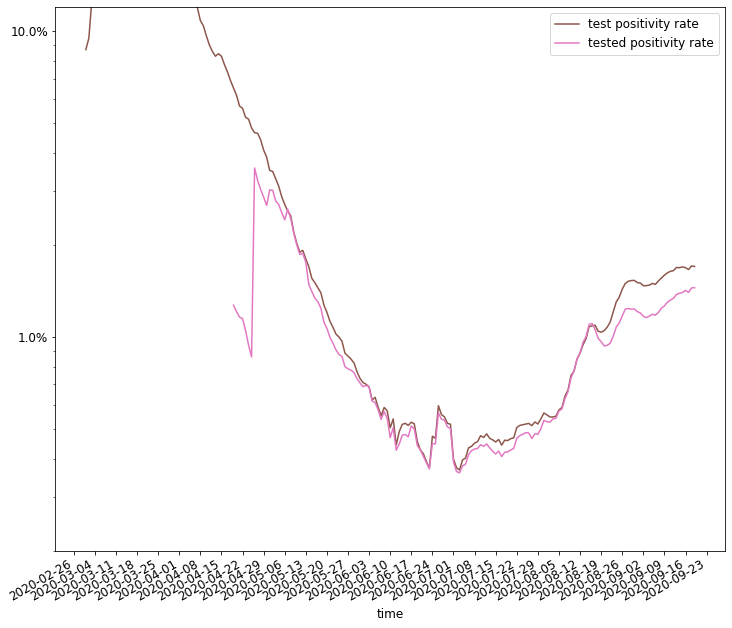

In [439]:
_, ax = plt.subplots()
ax.set(yscale='log', title='nuovi postivi / tamponi giornalieri (test positivity rate)')
covid19.plot.plot_data(ax, ds_italy['daily_tpr7'], label='test positivity rate',  marker=None)
data = ds_italy['daily_confirmed7'] / ds_italy['daily_tested7']
covid19.plot.plot_data(ax, data, label='tested positivity rate', marker=None, ratio=1.9)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.set(ylim=(0.002, 0.12))
_ = ax.legend()

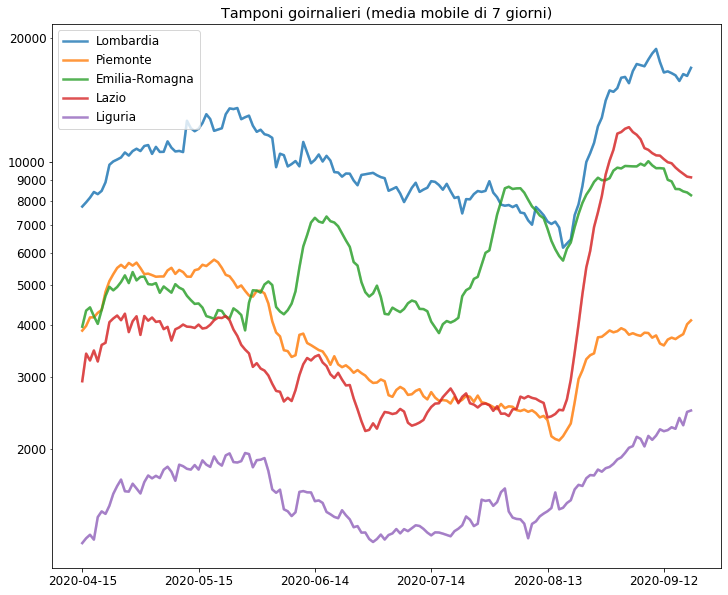

In [440]:
_, ax = plt.subplots()
ax.set(yscale='log', title='Tamponi goirnalieri (media mobile di 7 giorni)')
data = ds_italy_regions['daily_tests7']
covid19.plot.plot_xarray(data.sel(location=['Lombardia', 'Piemonte', 'Emilia-Romagna', 'Lazio', 'Liguria'], time=slice('2020-04-15', None)), hue='location', foreground_hue=None, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
_ = ax.legend(loc='upper left')

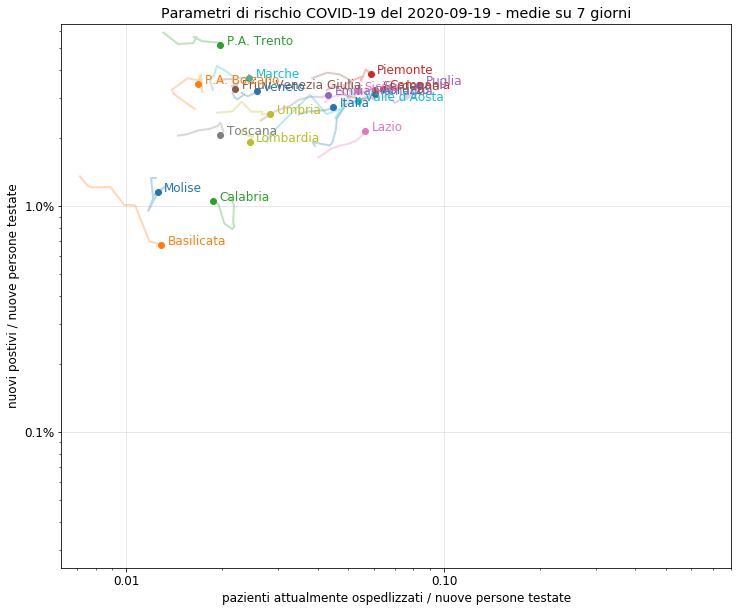

In [441]:
window = 7
rr = ds_italy_regions.isel(time=slice(-(window + 7), None)).rolling({'time': window}).mean().dropna('time')
rrr = ds_italy_regions
var = rr['daily_confirmed'] / np.maximum(rr['daily_tested'], 1)
var1 = rr['current_severe'] / np.maximum(rr['daily_tested'], 1)

it_var = (rr['daily_confirmed'].sum('location') / np.maximum(rr['daily_tested'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (rrr['current_severe'].sum('location') / np.maximum(rr['daily_tested'], 1).sum('location')).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)
   
xlim = (0.00625, 0.8)
ylim = (0.00025, 0.064)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='pazienti attualmente ospedlizzati / nuove persone testate',
    ylabel='nuovi postivi / nuove persone testate',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

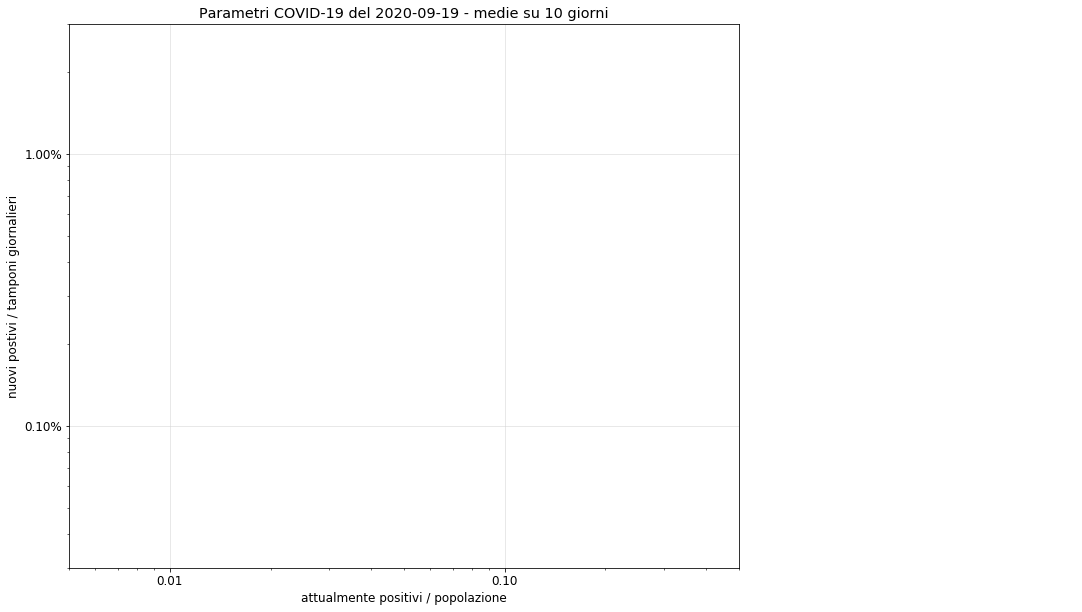

In [442]:
window = 10
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_confirmed7'] / np.maximum(rr['daily_tests7'], 1)
var1 = ds_italy_regions['current_severe'] / np.maximum(rr['population'], 1) * 100_000

it_var = (rr['daily_confirmed7'].sum('location') / np.maximum(rr['daily_tests7'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (ds_italy_regions['current_severe'].sum('location') / np.maximum(rr['population'], 1).sum('location')).expand_dims(location=['Italia'])* 100_000


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)

xlim = (0.005, 0.5)
ylim = (0.0003, 0.03)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='attualmente positivi / popolazione',
    ylabel='nuovi postivi / tamponi giornalieri',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

In [443]:
ds_italy_regions.sel(location="Liguria").to_dataframe()[['location', 'current_severe', 'current_critical', 'daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_tests7', 'daily_confirmed7', 'daily_deaths7', 'daily_tested7', 'confirmed', 'current_confirmed']].tail(20)


location  current_severe  current_critical  daily_tests  \
time                                                                 
2020-08-31  Liguria              38                 1       1360.0   
2020-09-01  Liguria              39                 5       1721.0   
2020-09-02  Liguria              38                 6       2678.0   
2020-09-03  Liguria              39                 7       2614.0   
2020-09-04  Liguria              48                 6       2169.0   
2020-09-05  Liguria              54                 7       2697.0   
2020-09-06  Liguria              62                 9       1586.0   
2020-09-07  Liguria              67                10        744.0   
2020-09-08  Liguria              85                11       2582.0   
2020-09-09  Liguria              87                11       2351.0   
2020-09-10  Liguria              91                11       2966.0   
2020-09-11  Liguria              96                12       2712.0   
2020-09-12  Liguria             109                11       2531.0   
2020-09-13  Liguria             115                11       1682.0   
2020-09-14  Liguria             126                12        995.0   
2020-09-15  Liguria             128                12       2445.0   
2020-09-16  Liguria             136                13       3335.0   
2020-09-17  Liguria             135                15       2295.0   
2020-09-18  Liguria             141                16       3955.0   
2020-09-19  Liguria             140                16       2666.0   

            daily_confirmed  daily_deaths  daily_tested  daily_tests7  \
time                                                                    
2020-08-31             44.0           0.0         993.0   1886.857143   
2020-09-01             19.0           0.0         901.0   1909.571429   
2020-09-02             47.0           0.0        1263.0   1957.428571   
2020-09-03             22.0           1.0        1445.0   2014.714286   
2020-09-04             47.0           0.0        1074.0   2033.428571   
2020-09-05             95.0           1.0        1660.0   2142.142857   
2020-09-06            111.0           2.0         829.0   2117.857143   
2020-09-07             59.0           2.0         424.0   2029.857143   
2020-09-08             64.0           1.0        1489.0   2152.857143   
2020-09-09             51.0           1.0        1301.0   2106.142857   
2020-09-10            114.0           0.0        1415.0   2156.428571   
2020-09-11             82.0           0.0        1499.0   2234.000000   
2020-09-12            112.0           0.0        1424.0   2210.285714   
2020-09-13             78.0           0.0         769.0   2224.000000   
2020-09-14             65.0           3.0         534.0   2259.857143   
2020-09-15            141.0           0.0        1399.0   2240.285714   
2020-09-16             73.0           1.0        1570.0   2380.857143   
2020-09-17             40.0           3.0        1146.0   2285.000000   
2020-09-18            158.0           0.0        1912.0   2462.571429   
2020-09-19             78.0           2.0        1446.0   2481.857143   

            daily_confirmed7  daily_deaths7  daily_tested7  confirmed  \
time                                                                    
2020-08-31         40.000000       0.000000    1065.285714      10951   
2020-09-01         41.000000       0.000000    1066.285714      10970   
2020-09-02         41.857143       0.000000    1070.571429      11017   
2020-09-03         39.714286       0.142857    1101.285714      11039   
2020-09-04         39.857143       0.142857    1096.000000      11086   
2020-09-05         46.714286       0.285714    1188.857143      11181   
2020-09-06         55.000000       0.571429    1166.428571      11292   
2020-09-07         57.142857       0.857143    1085.142857      11351   
2020-09-08         63.571429       1.000000    1169.142857      11415   
2020-09-09         64.142857       1.142857    1174.571429  

21

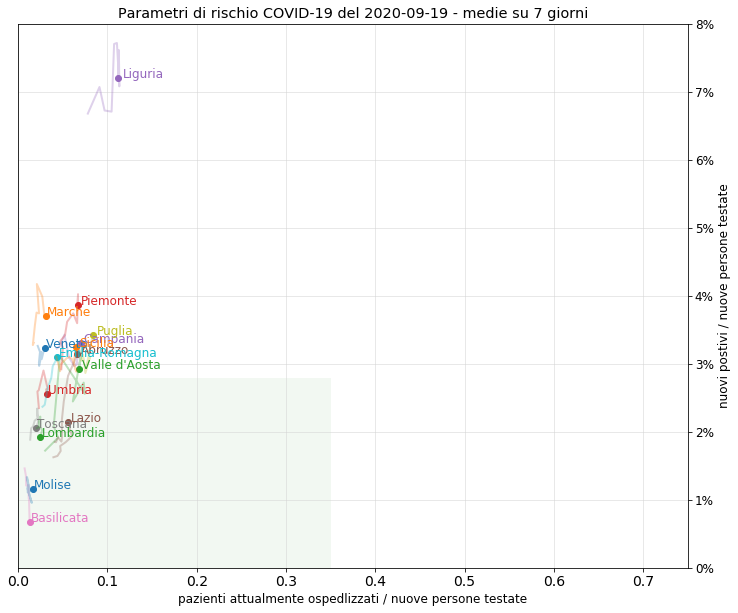

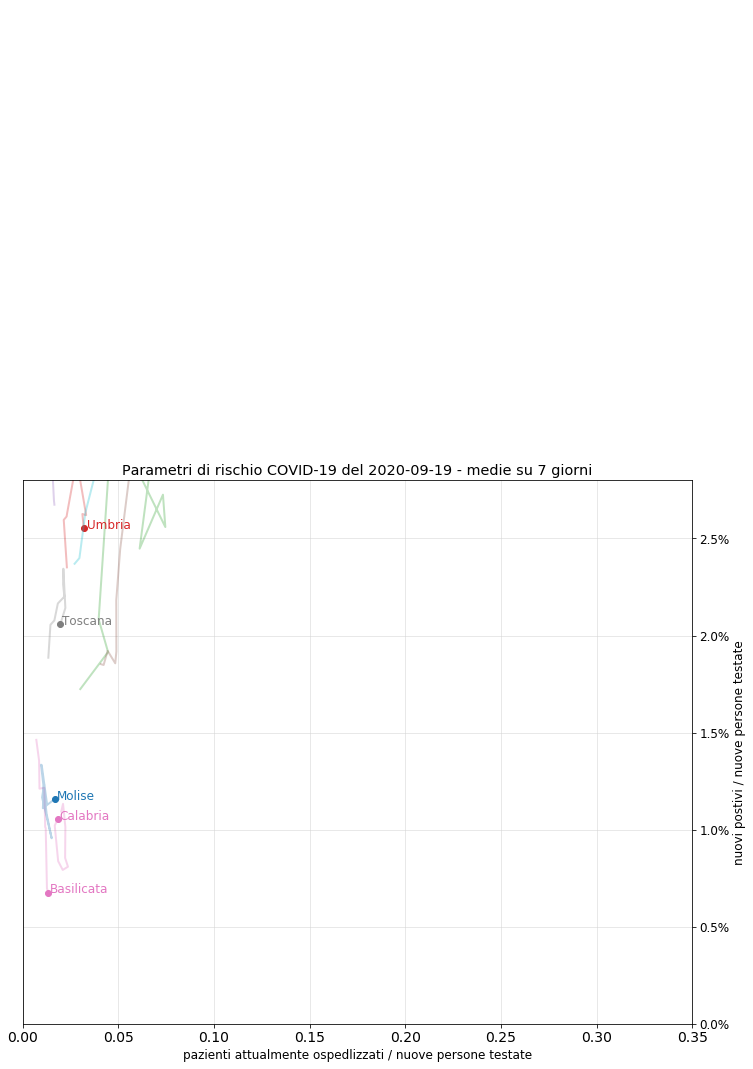

In [444]:
window = 7
rr = ds_italy_regions.isel(time=slice(-(window + 8), None)).rolling({'time': window}).mean().dropna('time')
it_rr = rr.sum('location')
rrr = ds_italy_regions
it_rrr = rrr.sum('location')
var = rr['daily_confirmed'] / np.maximum(rr['daily_tested'], 1)
it_var = it_rr['daily_confirmed'] / np.maximum(it_rr['daily_tested'], 1)
var1 = rrr['current_severe'] / np.maximum(rr['daily_tested'], 1)
it_var1 = it_rrr['current_severe'] / np.maximum(it_rr['daily_tested'], 1)
var2 = ((rrr['current_severe'] + rrr['current_critical']) / np.maximum(rrr['current_confirmed'], 1))

b = ['Veneto', 'Marche', "Valle d'Aosta", 'Umbria', 'Campania', 'Abruzzo', 'Basilicata', 'Toscana', 'Puglia', 'Emilia-Romagna', 'Molise', 'Sicilia']
r =  b + ['Lombardia', 'Piemonte', 'Liguria', 'Lazio']
_, ax = covid19.plot.subplots()
ax.fill([0, 0.35, 0.35, 0], [0, 0, 0.028, 0.028], 'green', alpha=0.05)
covid19.plot.scatter_xarray(var1.sel(location=r), var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    ylim=(0., 0.08), xlim=(0., 0.75),
    xlabel='pazienti attualmente ospedlizzati / nuove persone testate',
    ylabel='nuovi postivi / nuove persone testate',
)

rs = b + ['Sardegna', 'Friuli Venezia Giulia', 'P.A. Bolzano', 'P.A. Trento', 'Calabria']
ax = covid19.plot.scatter_xarray(var1.sel(location=rs), var)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=1))
_ = ax.set(
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    ylim=(0., 0.028), xlim=(0., 0.35),
    xlabel='pazienti attualmente ospedlizzati / nuove persone testate',
    ylabel='nuovi postivi / nuove persone testate',
)

len(set(r) | set(rs))
#rr['current_severe'].isel(time=-1)

In [445]:
tmp = ds_italy_regions.sel(location='Liguria').to_dataframe()
tmp['tpr'] = tmp['daily_confirmed'] / tmp['daily_tests']
tmp['tpr7'] = tmp['daily_confirmed7'] / tmp['daily_tests7']
tmp.tail(12)

current_severe  current_critical  deaths  current_confirmed  \
time                                                                      
2020-09-08              85                11    1578                860   
2020-09-09              87                11    1579                907   
2020-09-10              91                11    1579                941   
2020-09-11              96                12    1579                994   
2020-09-12             109                11    1579               1088   
2020-09-13             115                11    1579               1143   
2020-09-14             126                12    1582               1200   
2020-09-15             128                12    1582               1251   
2020-09-16             136                13    1583               1323   
2020-09-17             135                15    1586               1358   
2020-09-18             141                16    1586               1414   
2020-09-19             140                16    1588               1433   

            confirmed   tests    tested  dimessi_guariti  \
time                                                       
2020-09-08      11415  254193  137135.0             8977   
2020-09-09      11466  256544  138436.0             8980   
2020-09-10      11580  259510  139851.0             9060   
2020-09-11      11662  262222  141350.0             9089   
2020-09-12      11774  264753  142774.0             9107   
2020-09-13      11852  266435  143543.0             9130   
2020-09-14      11917  267430  144077.0             9135   
2020-09-15      12058  269875  145476.0             9225   
2020-09-16      12131  273210  147046.0             9225   
2020-09-17      12171  275505  148192.0             9227   
2020-09-18      12329  279460  150104.0             9329   
2020-09-19      12407  282126  151550.0             9386   

            casi_da_sospetto_diagnostico  casi_da_screening  ...  \
time                                                         ...   
2020-09-08                        8812.0             2603.0  ...   
2020-09-09                        8814.0             2652.0  ...   
2020-09-10                        8894.0             2686.0  ...   
2020-09-11                        8914.0             2748.0  ...   
2020-09-12                        8984.0             2790.0  ...   
2020-09-13                        9014.0             2838.0  ...   
2020-09-14                        9030.0             2887.0  ...   
2020-09-15                        9060.0             2998.0  ...   
2020-09-16                        9085.0             3046.0  ...   
2020-09-17                        9080.0             3091.0  ...   
2020-09-18                        9217.0             3112.0  ...   
2020-09-19                        9219.0             3188.0  ...   

            daily_mortality7  daily_prevalence7  daily_tests_pm7  \
time                                                               
2020-09-08          0.638852          40.612754      1375.357769   
2020-09-09          0.730117          40.977813      1345.514239   
2020-09-10          0.638852          49.374157      1377.639384   
2020-09-11          0.638852          52.568419      1427.196071   
2020-09-12          0.547588          54.119918      1412.046144   
2020-09-13          0.365058          51.108185      1420.807548   
2020-09-14          0.456323          51.655773      1443.714966   
2020-09-15          0.365058          58.683148      1431.211714   
2020-09-16          0.365058          60.690970      1521.016096   
2020-09-17          0.638852          53.937388      1459.777539   
2020-09-18          0.638852          60.873499      1573.219457   
2020-09-19          0.821382          57.770502      1585.540180   

            daily_tested_pm7  daily_prevalence_screening7  daily_tpr7  \
time                                                                    
2020-09-08        746.909620                    25.280299    0.02952

In [463]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

START_FIT = '2020-02-23'
STOP_FIT = '2020-04-01'

SHOWUNTIL = ds_italy.time[-1].values + 30 * DAY

EXTRAPOLATE = (np.datetime64('2020-02-23'), SHOWUNTIL)
XLIM = EXTRAPOLATE

FIT_PARAMS = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-21', '2020-09-05'],
    'current_severe_pm': ['2020-08-15', '2020-09-17'],
    'current_critical_pm': ['2020-08-10', None],
    'daily_mortality7': ['2020-08-25', None],
}
RATIO = {
}
LABEL = {
    'current_severe': 'pazienti attualmente ricoverati in reparto',
    'current_confirmed': 'attualmente positivi',
    'current_severe_pm': 'pazienti attualmente ricoverati in reparto',
    'current_critical': 'pazienti attualmente in terapia intensiva',
    'current_critical_pm': 'pazienti attualmente in terapia intensiva',
    'daily_tests7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_deaths': 'decessi giornalieri',
    'daily_deaths7': 'decessi giornalieri (media su 7 giorni)',
    'daily_confirmed7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_prevalence7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_prevalence_screening7': 'nuovi casi da screening (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_mortality7': 'decessi giornalieri (media su 7 giorni)',
}

In [464]:
fits = {}
for kind, breaks in FIT_PARAMS.items():
    if isinstance(breaks, int):
        breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in FIT_PARAMS['current_severe']]
    fits[kind] = covid19.fit.fit_exponential_segments(ds_italy[kind], breaks=breaks, min_value=0, valid_ratio=2)
fits

skipping start=2020-08-15T00:00:00 stop=2020-09-16T00:00:00
skipping start=2020-08-25T00:00:00 stop=None


{'daily_tests_pm7': [],
 'daily_prevalence7': [ExponentialFit(t_0=numpy.datetime64('2020-06-28T13:18:04'), T_d=numpy.timedelta64(1312339,'s'), r2=0.9743722207533361, start=numpy.datetime64('2020-07-21T00:00:00.000000000'), stop=numpy.datetime64('2020-09-04T00:00:00.000000000'))],
 'current_severe_pm': [],
 'current_critical_pm': [ExponentialFit(t_0=numpy.datetime64('2020-08-18T13:39:20'), T_d=numpy.timedelta64(1449390,'s'), r2=0.9814888432777886, start=numpy.datetime64('2020-08-10T00:00:00.000000000'), stop=numpy.datetime64('2020-09-19T00:00:00.000000000'))],
 'daily_mortality7': []}

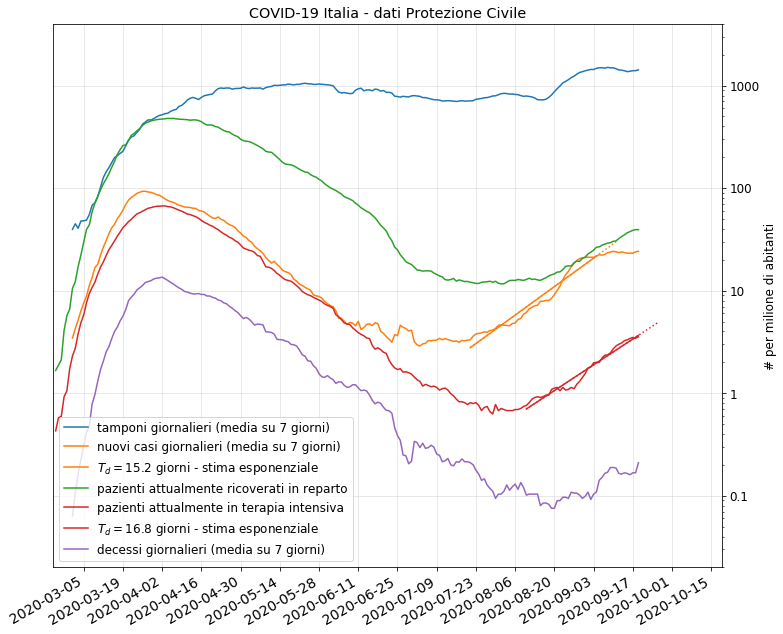

In [465]:
SHOW = None  # ["current_critical_pm"]

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.02, 4000)})

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    if SHOW is not None and kind not in SHOW:
        continue
    label = LABEL[kind]
    ratio = RATIO.get(kind, 1.)
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=14, marker=None, ratio=ratio)
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)
    
_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
_ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = ax.legend(loc='lower left')

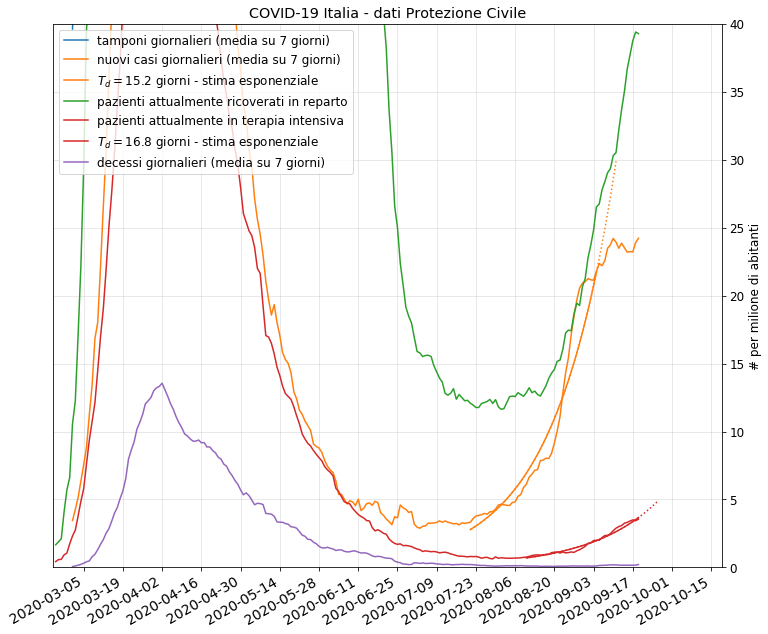

In [466]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'ylim': (0, 40)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    ratio = RATIO.get(kind, 1)
    label = LABEL[kind] + ('' if ratio == 1 else f' / {ratio}')
    covid19.plot.plot_data(ax, ds_italy[kind] / ratio, label=label, color=color, date_interval=14, marker=None)
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))

In [467]:
REGIONS_FIT_PARAMS_DEFAULT = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-10', None],
    'current_severe_pm': ['2020-07-20', None],
    'current_critical_pm': ['2020-07-25', None],
    'daily_mortality7': [],
}
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'daily_prevalence7': [],
        'current_critical_pm': ['2020-08-05', None],
    },
    'Lazio': {
        'daily_prevalence7': [],
        'current_severe_pm': [],
    },
    'Campania': {
    },
    'Sicilia': {
        'daily_prevalence7': ['2020-07-17', None],
    },
    'Veneto': {
        'daily_prevalence7': ['2020-07-15', None],
        'current_severe_pm': ['2020-08-10', None],
    },
    'Emilia-Romagna': {
        'daily_prevalence7': ['2020-06-10', None],        
    },
    'Sardegna': {
        'daily_prevalence7': ['2020-07-10', '2020-09-05', None],
        'current_severe_pm': ['2020-08-01', None],
        'current_critical_pm': [],
    },
    'Liguria': {
        'current_severe_pm': [],
    },
    'Puglia': {
        'daily_prevalence7': ['2020-07-20', '2020-09-10'],
    },
    'Basilicata': {
        'daily_prevalence7': ['2020-07-20', None],
    },
 }

STOP_FIT = '2020-04-03'

region_fits = {}
for region in REGIONS:
    params = REGIONS_FIT_PARAMS_DEFAULT.copy()
    params.update(REGIONS_FIT_PARAMS.get(region, {}))
    region_fits[region] = {}
    for kind, breaks in params.items():
        if isinstance(breaks, int):
            breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in params['current_severe']]
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds_italy_regions.sel(location=region)[kind], breaks=breaks, min_value=0, valid_ratio=1.5)

skipping start=2020-07-20T00:00:00 stop=None
skipping start=2020-07-25T00:00:00 stop=None
skipping start=2020-07-20T00:00:00 stop=None
skipping start=2020-07-20T00:00:00 stop=None
skipping start=2020-07-25T00:00:00 stop=None
skipping start=2020-09-05T00:00:00 stop=None
skipping start=2020-07-25T00:00:00 stop=None
skipping start=2020-07-25T00:00:00 stop=None
skipping start=2020-07-20T00:00:00 stop=None
skipping start=2020-07-20T00:00:00 stop=None
skipping start=2020-07-25T00:00:00 stop=None


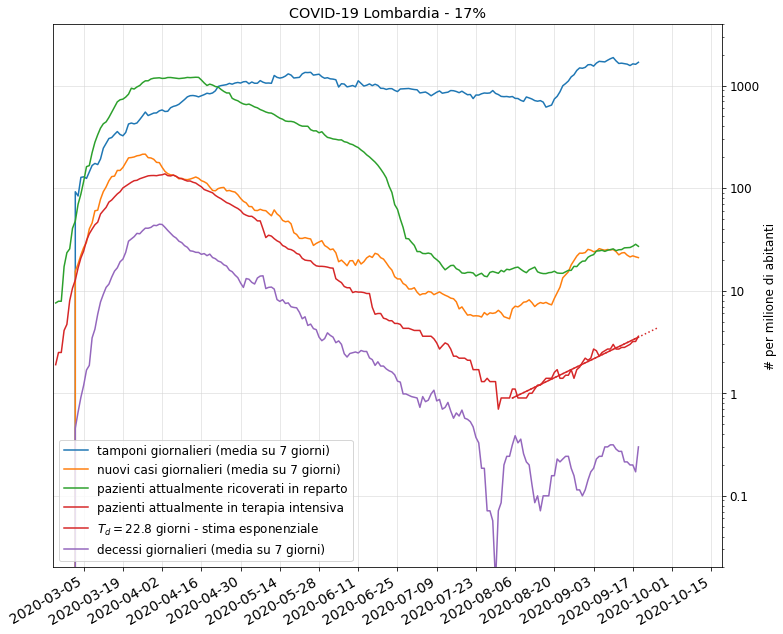

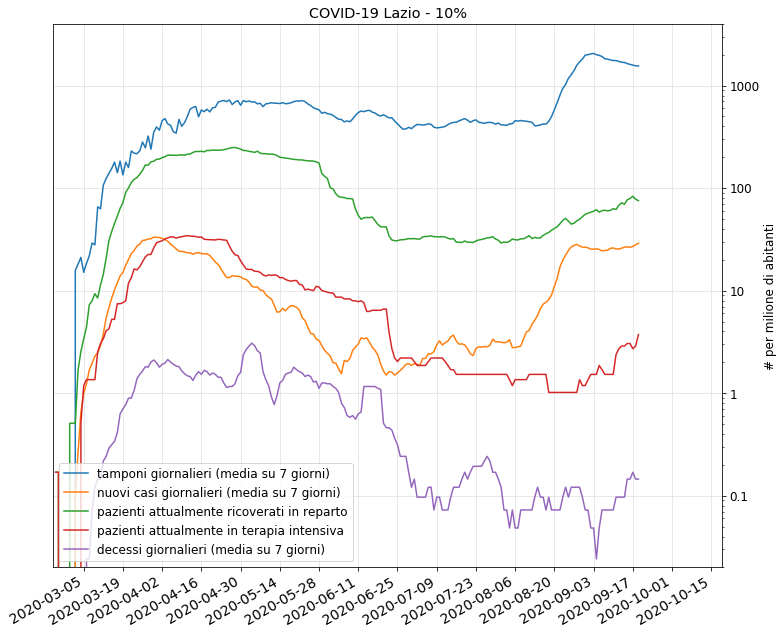

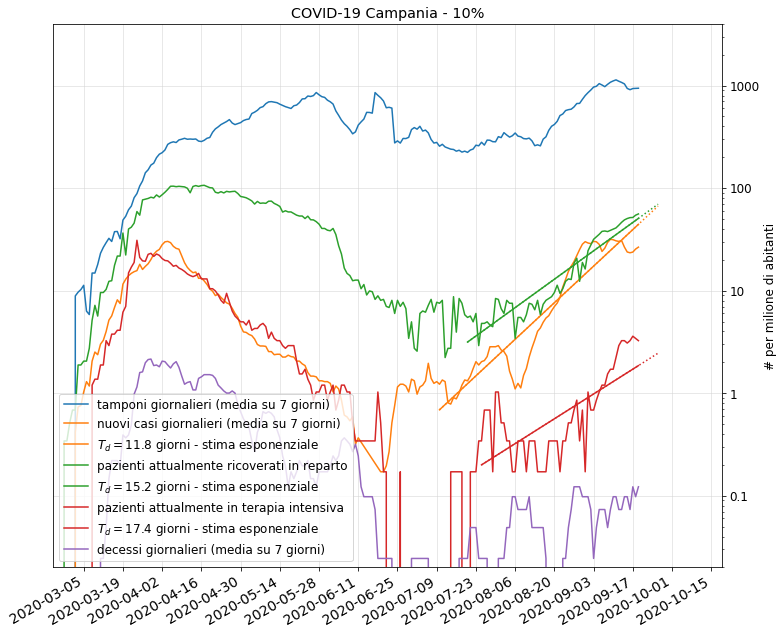

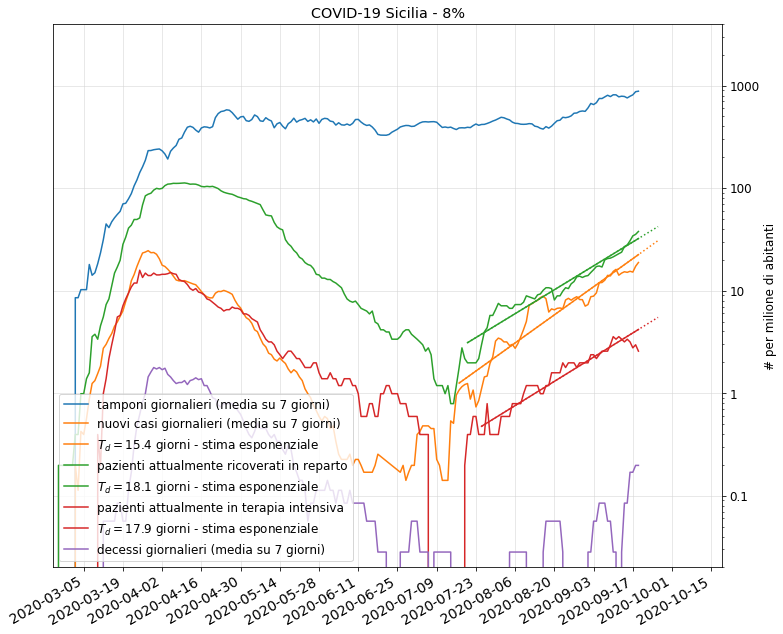

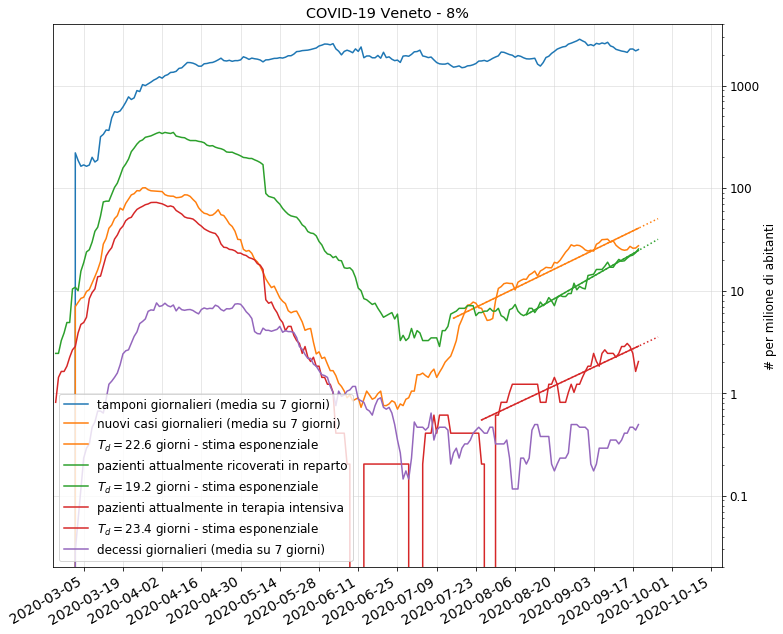

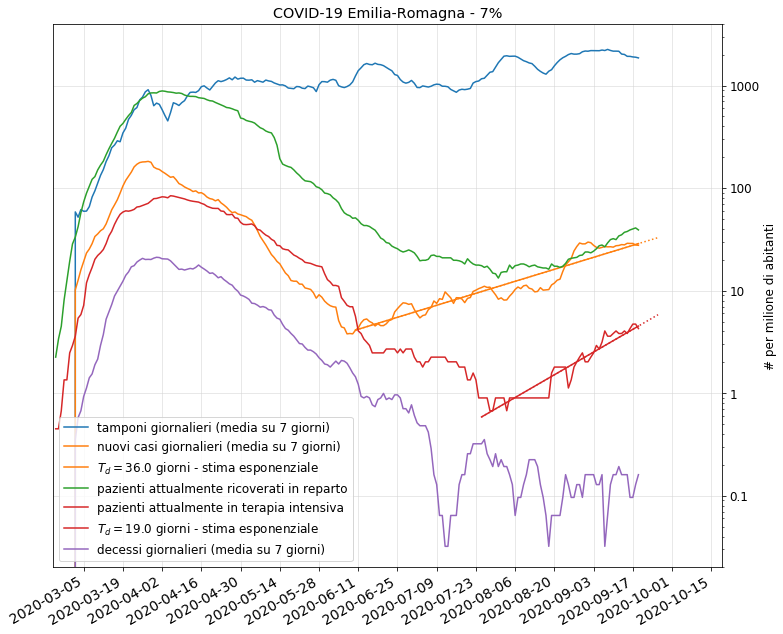

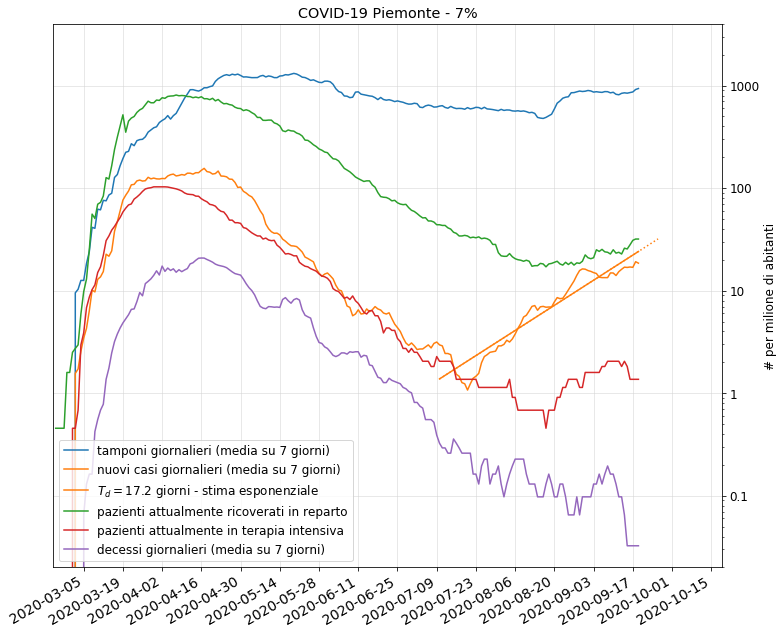

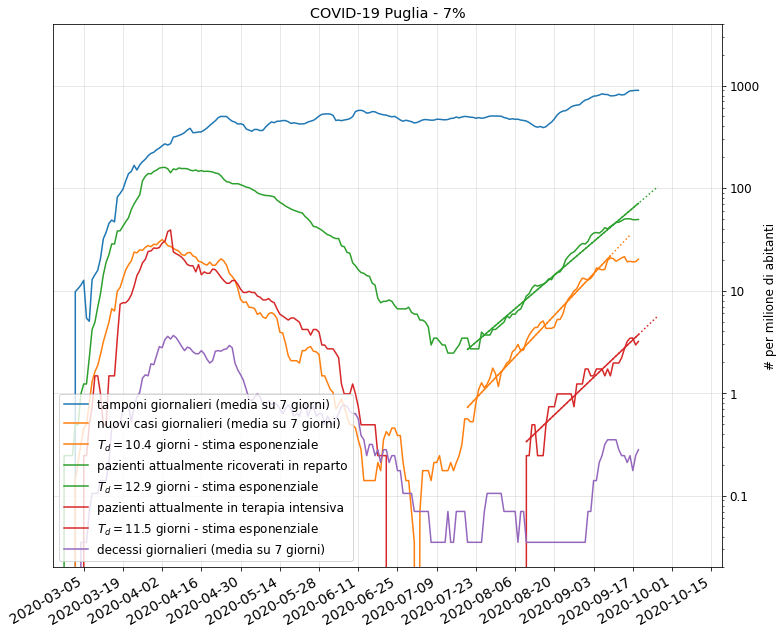

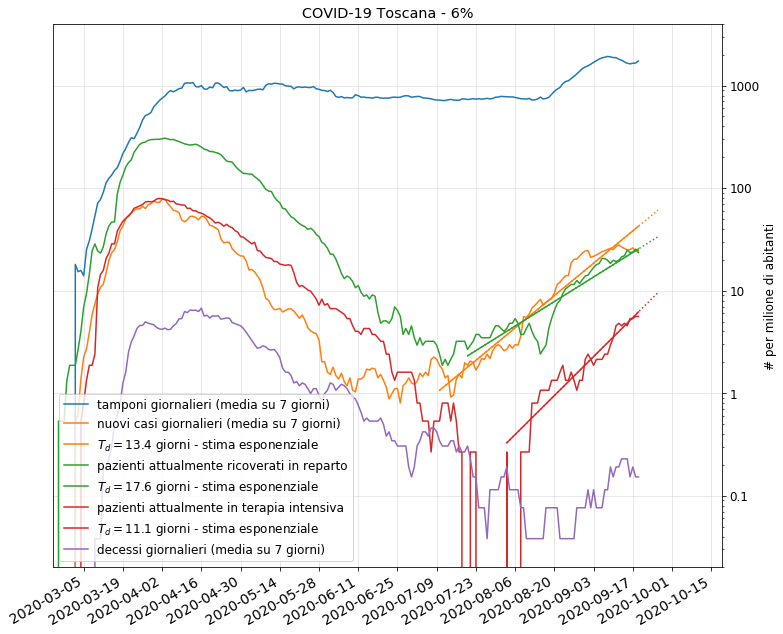

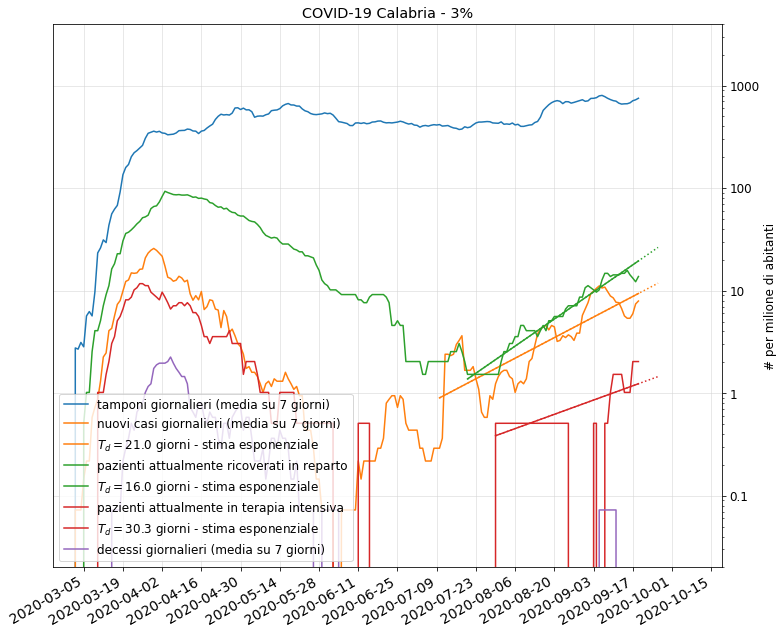

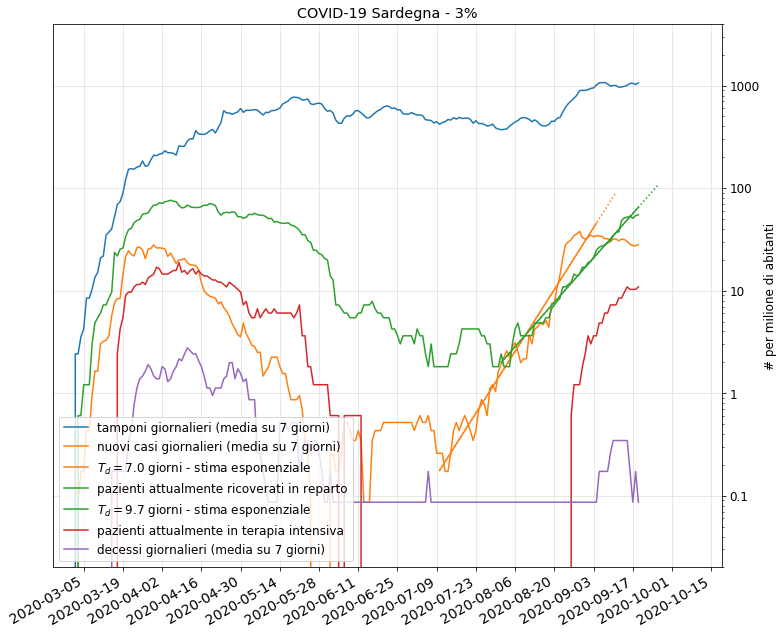

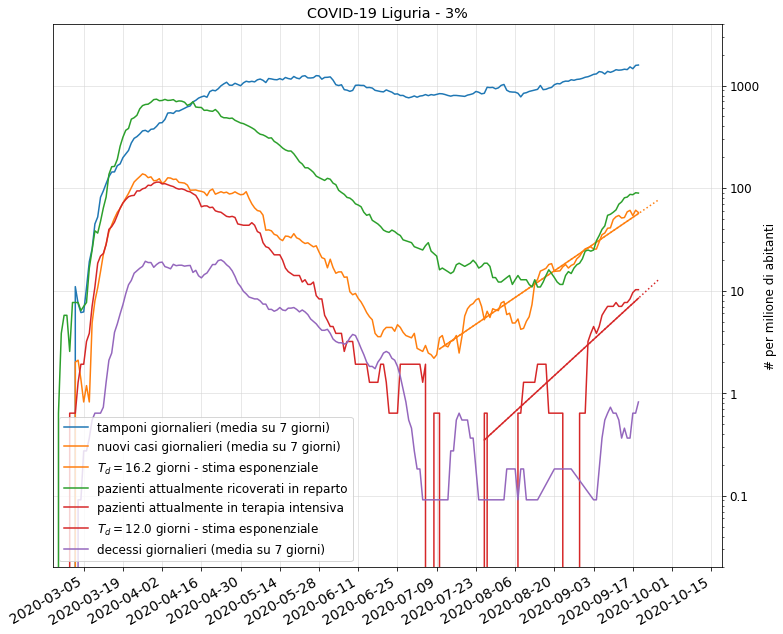

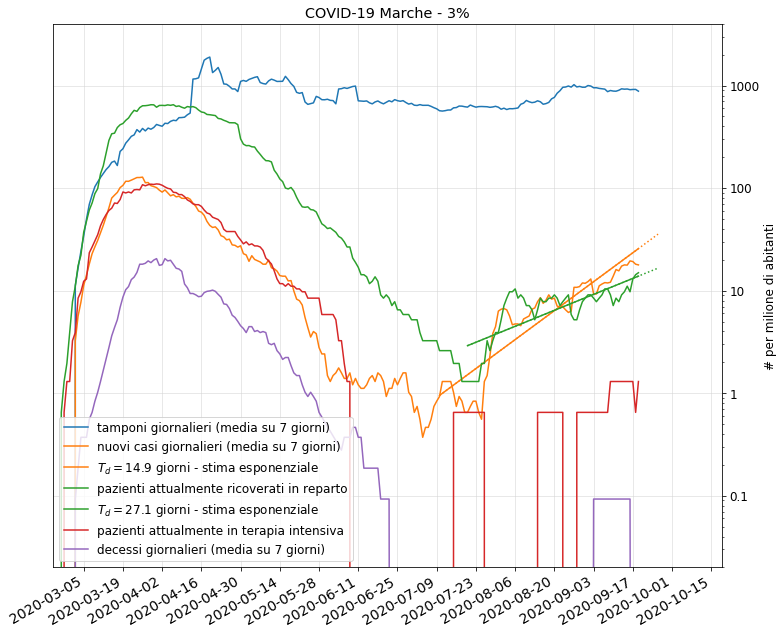

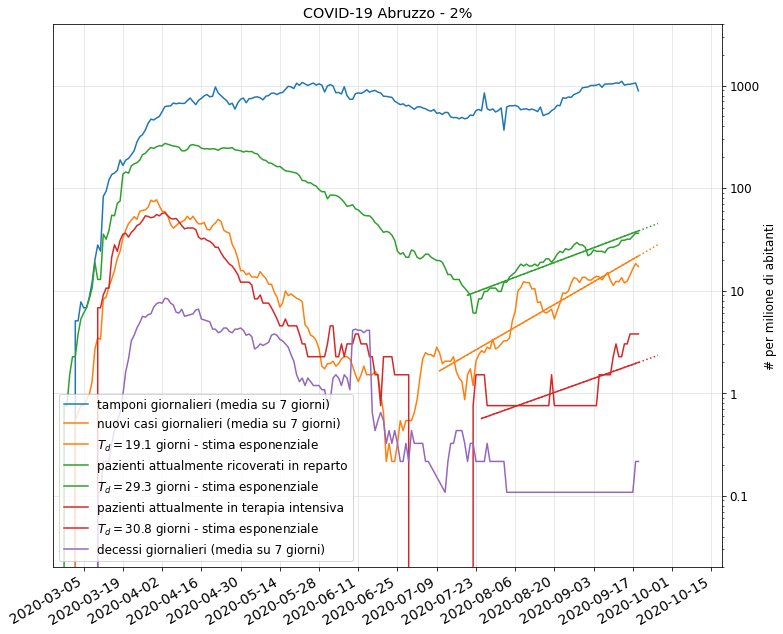

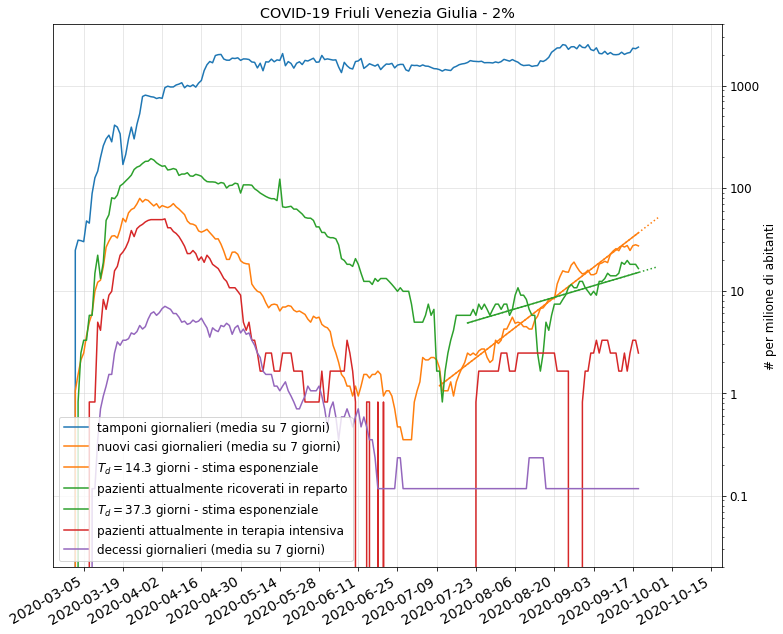

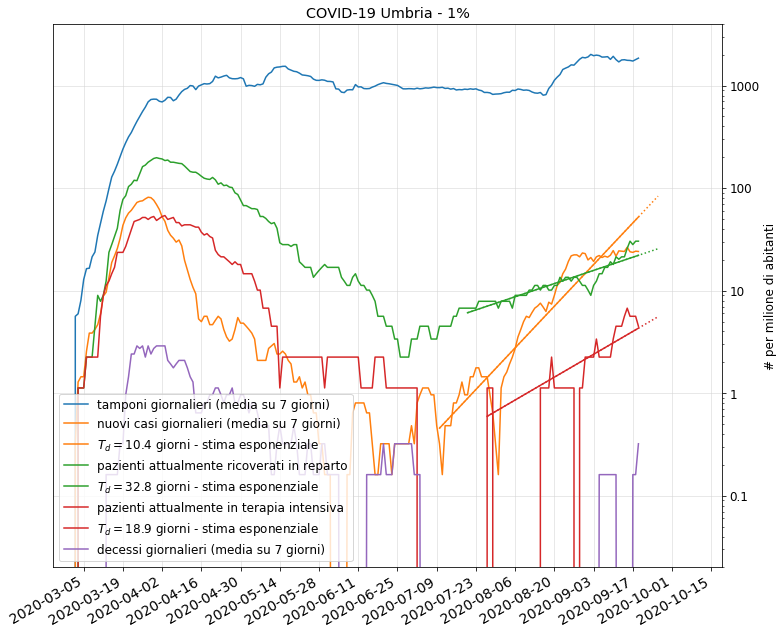

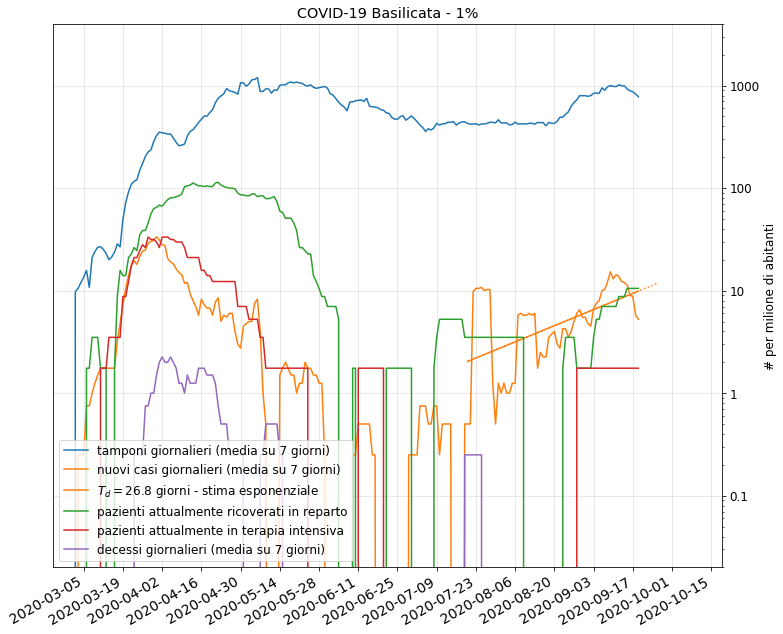

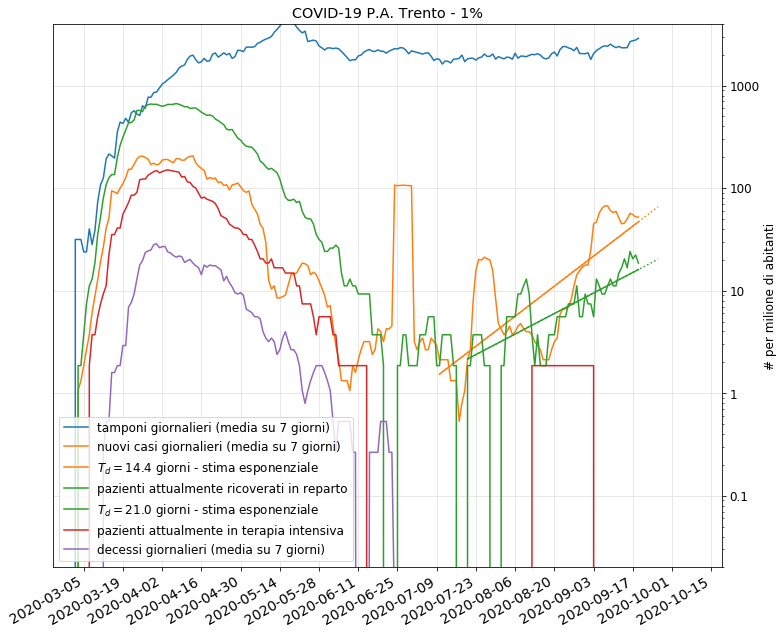

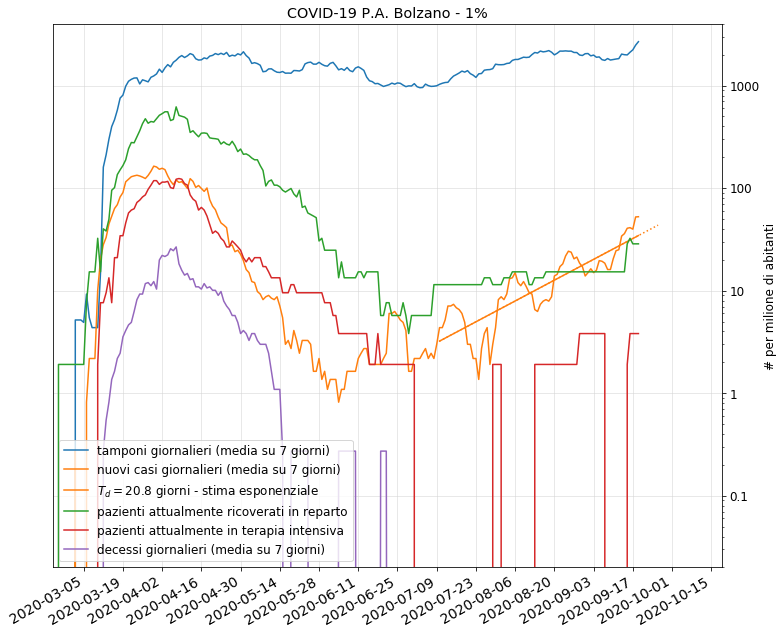

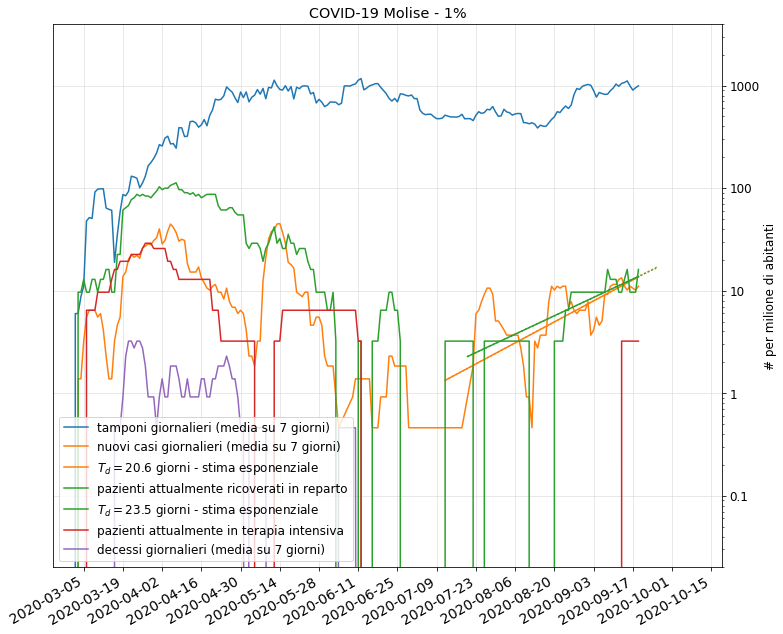

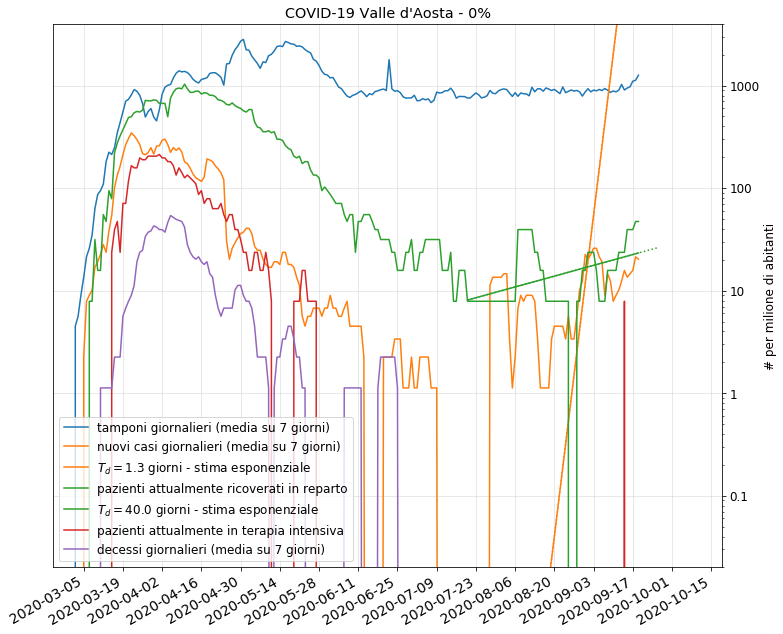

In [468]:
for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.02, 4000)})
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color in zip(fit_kinds.items(), PALETTE_ONE):
        label = LABEL[kind]
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color, marker=None, date_interval=14)
        for fit in fitsk:
            covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])
    ax.set_title(f'COVID-19 {region} - {ds_region.population.values / ds_italy.population.values * 100:.0f}%')
    ax.set(xlabel="", ylabel="# per milione di abitanti")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.legend(loc='lower left')


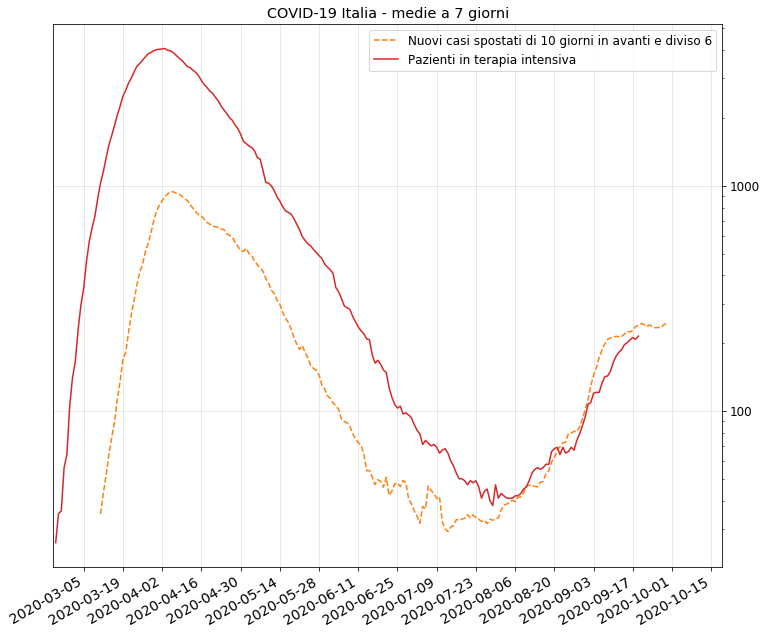

In [469]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=10, ratio=6, label='Nuovi casi spostati di 10 giorni in avanti e diviso 6', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, label='Pazienti in terapia intensiva', color='tab:red', date_interval=14)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='', xlabel='')

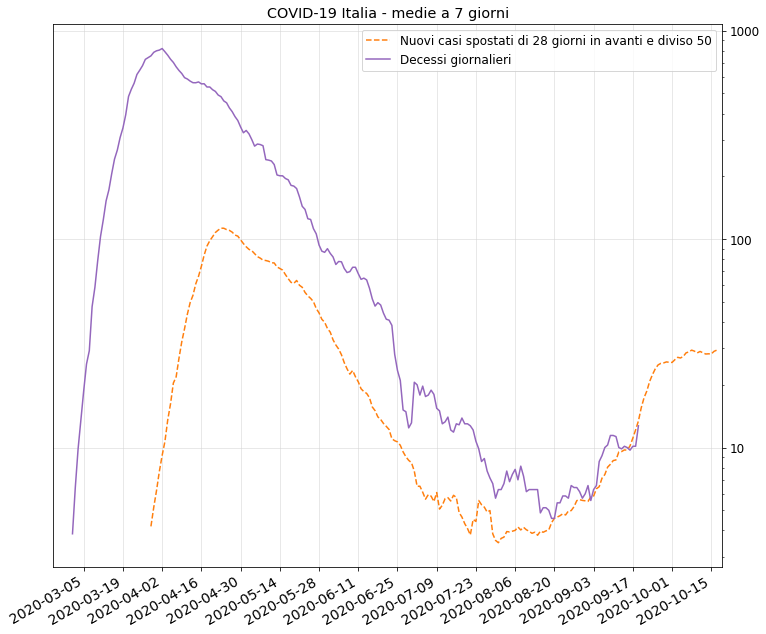

In [470]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=28, ratio=50, label='Nuovi casi spostati di 28 giorni in avanti e diviso 50', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Decessi giornalieri', color='tab:purple', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='', xlabel='')

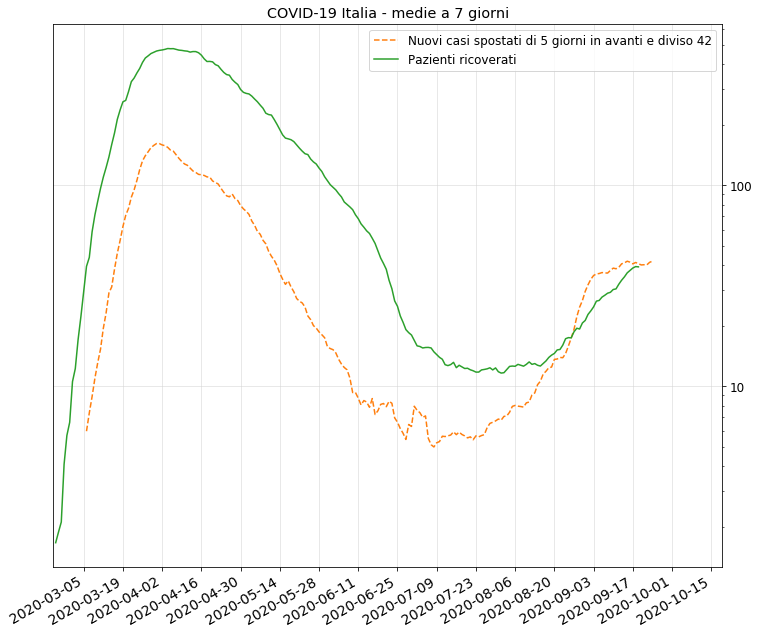

In [471]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=5, ratio=35, label='Nuovi casi spostati di 5 giorni in avanti e diviso 42', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_severe_pm'], marker=None, label='Pazienti ricoverati', color='tab:green', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='', xlabel='')

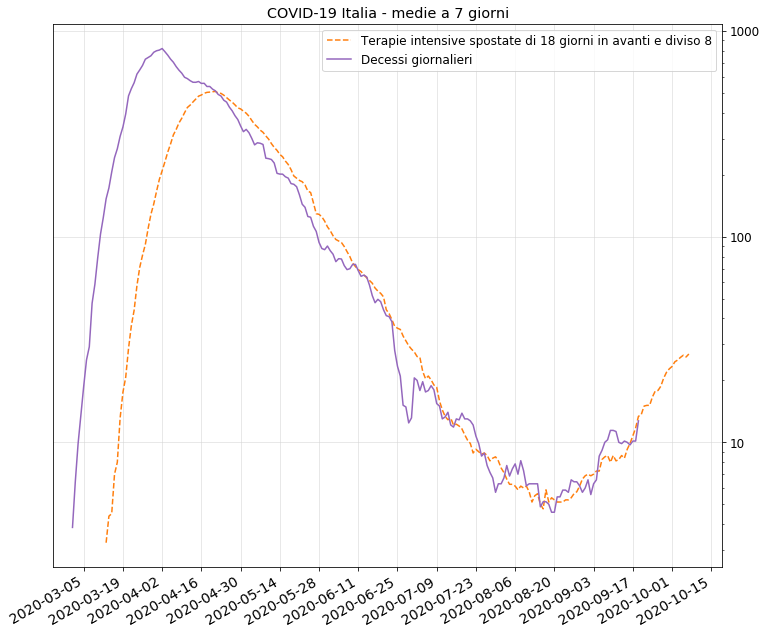

In [472]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, delay=18, ratio=8, label='Terapie intensive spostate di 18 giorni in avanti e diviso 8', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Decessi giornalieri', color='tab:purple', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='', xlabel='')